# Working with FITS Files

---

reading headers, plotting light curves and images

show people that everything lightkurve does is very tedious and painful to do yourself. If you want to write a paper, you'll need to do the tedious stuff.

## Learning Goals

- Open and explore astronomical data stored in FITS (Flexible Image Transport System) files.
- Load FITS files using `astropy.io.fits` and inspect the file structure and metadata.
- Visualize image data from FITS files using `matplotlib`.

## Table of Contents

- [Introduction](#Introduction)
- [Imports and Setup](#Imports-and-Setup)
- [Exercise](#Exercise)

## Introduction

Dr. Nefarious, an evil mastermind and lover of jazz, has scrambled the index to the MAST Archive! Without it, astronomers can't locate critical datasets, and the longer is stays scrambled, the closer he gets to wiping the archive forever. Your next objective is clear: restore access to the Archive's data using powerful querying tools.
Your goal is to track down the exact files needed to uncover Dr. Nefarious’s next move and send him running back to his data void.

Let’s bring the Archive back online. Query away, agent.

In this tutorial, we will learn how to search for, filter, and access TESS data on the cloud with the ``astroquery.mast`` module.

## Imports and Setup

We will import the following packages:
- FILL IN

In [2]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt

## Opening a Target Pixel File

TESS (the Transiting Exoplanet Survey Satellite) looks for planets by watching stars get slightly dimmer when a planet passes in front of them.

Instead of taking one huge picture of the whole sky, TESS also downloads small cutouts called Target Pixel Files (TPFs). Each TPF is like a little movie of a star, where each “frame” is called a cadence (about 2 minutes long). TPFs are used to analyze the brightness variations of stars over time, which can reveal phenomena such as transiting exoplanets, stellar variability, and other astrophysical events.

Before we dive in, let’s define a few important terms:

- Sector: TESS observes the sky in large strips. Each strip is called a sector (about a month of data).

- HDU (Header Data Unit): A FITS file is made up of “units” that contain either data (like an image) or metadata (information about the observation).

- BJD (Barycentric Julian Date): A standard time system used in astronomy.

- TBJD (TESS BJD): A simpler version of BJD, offset by 2457000.

- Cadence: The time between measurements (2 minutes for TPFs).

### Looking Inside a TPF

First, let's load in a TPF. Normally, we would search for this file through the MAST Archive, but to keep things simple, we'll just open it directly from the cloud. This TPF is for the star AU Mic. After loading the file to memory, we can use the `info` method to examine its structure.

In [26]:
target_pixel_file = 's3://stpubdata/tess/public/tid/s0027/0000/0004/4142/0236/tess2020186164531-s0027-0000000441420236-0189-s_tp.fits'

hdul_tpf = fits.open(target_pixel_file, fsspec_kwargs={'anon': True})
hdul_tpf.info()

Filename: <class 's3fs.core.S3File'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   17546R x 11C   [D, E, J, 143J, 143E, 143E, 143E, 143E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


You'll notice:

- `PRIMARY` (0): Primary header that contains metadata about the observation.
- `PIXELS` (1): Table of timestamps, fluxes, and other information.
- `APERTURE` (2): The aperture mask used to extract the light curve.
- `TARGET COSMIC RAY` (3): Currently unused.

### Inspecting the Headers

To inspect the metadata, we can look at the headers of each HDU. The primary header (HDU 0) contains general information about the observation, while HDU 1 has more specific details about the data. 

In the cell below, we display the header values for the primary header (HDU 0) by accessing the `header` attribute. Each line shows a keyword, its value, and a brief description comment.

In [27]:
hdul_tpf[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    3 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-08-29'         / file creation date.                            
TSTART  =    2036.283336447470 / observation start time in BTJD                 
TSTOP   =    2060.647593255853 / observation stop time in BTJD                  
DATE-OBS= '2020-07-05T18:46:

### Inspecting the Data Table

The first extension (HDU 1) is a table with lots of useful columns. We can display these columns by accessing the `columns` attribute of the HDU.

In [28]:
hdul_tpf[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '143J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,13)'
    name = 'FLUX'; format = '143E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,13)'
    name = 'FLUX_ERR'; format = '143E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,13)'
    name = 'FLUX_BKG'; format = '143E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,13)'
    name = 'FLUX_BKG_ERR'; format = '143E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,13)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

Some especially important columns are:

- `TIME`: timestamps (in TBJD).

- `RAW_CNTS`: raw pixel values.

- `FLUX`: calibrated pixel values (corrected for the instrument).

- `FLUX_BKG`: background light level.

Now let’s pull out the time stamps and the calibrated flux values (our main signal).

In [29]:
tess_bjds = hdul_tpf[1].data["TIME"]
calibrated_fluxes = hdul_tpf[1].data["FLUX"]
hdul_tpf.close()

print(type(calibrated_fluxes))
print(calibrated_fluxes.shape)

<class 'numpy.ndarray'>
(17546, 13, 11)


The shape of this data tells us that there are 17,546 cadences (rows), and each cadence is a 13x11 image of pixels.

### Plotting a Single Cadence

Now, let's visualize the calibrated fluxes for a single cadence (the fifth one, index 4). This will give us an idea of what the star and its surroundings look like at that moment in time. The image will show us the star (bright pixels) and the surrounding sky (dimmer pixels).

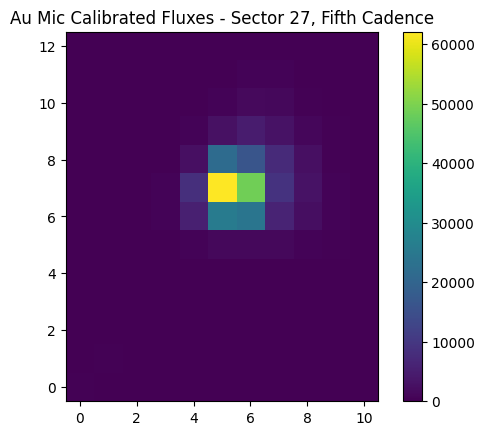

In [30]:
# Plot the calibrated fluxes for the fifth cadence (index 4)
plt.imshow(calibrated_fluxes[4,:,:], origin="lower")
plt.title("Au Mic Calibrated Fluxes - Sector 27, Fifth Cadence")
plt.colorbar()
plt.show()

## Opening a Light Curve File

Now that we've seen how to open and explore a TPF, let's look at a light curve file. A light curve file contains a timeseries of brightness measurements for a star, extracted from the TPF. We'll look at the light curve for the same star, AU Mic.

In [31]:
light_curve_file = 's3://stpubdata/tess/public/tid/s0027/0000/0004/4142/0236/tess2020186164531-s0027-0000000441420236-0189-s_lc.fits'

hdul_lc = fits.open(light_curve_file, fsspec_kwargs={'anon': True})
hdul_lc.info()

Filename: <class 's3fs.core.S3File'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    161   17546R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 13)   int32   


The output shows us three HDUs:

- `PRIMARY` (0): Primary header that contains metadata about the observation.
- `LIGHTCURVE` (1): Table of timestamps, fluxes, and other information.
- `APERTURE` (2): The aperture mask used to extract the light curve.

The information we want is in the `LIGHTCURVE` extension (HDU 1).

In [24]:
hdul_lc[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

## Exercise

To unlock your clue for this challenge, you'll need to use the workflow described in this notebook to query for observations and fetch product files, and locate data on the cloud.

First, write a query that satisfies the following criteria:
- Cone search around the M11 object with a radius of 0.2 degrees.
- Image observations intended for science.
- Wavelength region is "OPTICAL" or "INFRARED".
- Observation description (title) contains the word "survey".
- Observation exposure time is between 785 and 794 seconds.

## Additional Resources

- FILL IN

## About this Notebook:
If you have comments or questions on this notebook, please open a [GitHub issue on tike_content](https://github.com/spacetelescope/tike_content/issues/new) contact us through the [Archive Help Desk e-mail](mailto:archive@stsci.edu).

**Author:** Sam Bianco

**Last Updated:** September 2025

---

[Top of Page](#top)

<img style=float:right; src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

In [7]:
Observations.enable_cloud_dataset()
Observations.get_cloud_uris(filtered)

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


['s3://stpubdata/tess/public/tid/s0027/0000/0004/4142/0236/tess2020186164531-s0027-0000000441420236-0189-s_lc.fits',
 's3://stpubdata/tess/public/tid/s0027/0000/0004/4142/0236/tess2020186164531-s0027-0000000441420236-0189-s_tp.fits',
 's3://stpubdata/tess/public/tid/s0027/0000/0004/4141/8475/tess2020186164531-s0027-0000000441418475-0189-s_lc.fits',
 's3://stpubdata/tess/public/tid/s0027/0000/0004/4141/8475/tess2020186164531-s0027-0000000441418475-0189-s_tp.fits',
 's3://stpubdata/tess/public/tid/s0001/0000/0004/4142/0236/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits',
 's3://stpubdata/tess/public/tid/s0001/0000/0004/4142/0236/tess2018206045859-s0001-0000000441420236-0120-s_tp.fits',
 's3://stpubdata/tess/public/tid/s0095/0000/0004/4141/8475/tess2025206162959-s0095-0000000441418475-0292-s_lc.fits',
 's3://stpubdata/tess/public/tid/s0095/0000/0004/4141/8475/tess2025206162959-s0095-0000000441418475-0292-s_tp.fits',
 's3://stpubdata/tess/public/tid/s0095/0000/0004/4142/0236/tess2